In [29]:
import os
import tempfile
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
from Bio import SeqIO
from Bio.Seq import Seq
from Bio import AlignIO
from Bio.Align.Applications import MafftCommandline
from shutil import copyfile

In [30]:

wd = '/Volumes/Diane-Saunders/loizos/MARPLE/fungicide_genes/PGT'
primers = os.path.join(wd, 'fungPrimers.fna')
cds = os.path.join(wd, 'fung_pgt_cds.fna')

refdict = {
    'GCA_000149925.1_ASM14992v1_genomic': 'CRL75',
    'GCA_002762355.2_KSU_Pgt_99KS76A_2.0_genomic': '99KS76A',
    'GCA_008520325.1_Pgt_Ug99_genomic': 'Ug99',
    'GCA_008522505.1_Pgt_210_genomic': 'Pgt21-0',
    'GCA_903797515.1_Puccinia_graminis_f._sp._tritici_UK-01_genomic': 'UK-01'
}

In [31]:

sequences = {}
cds_sequences = {}

for record in SeqIO.parse(cds, 'fasta'):
    cds_sequences[record.id] = str(record.seq)

for file in os.listdir(wd):
    if file.endswith('.blastn.tsv'):
        filename = file.split('.fna.blastn.tsv')[0]
        refname = refdict[filename]
        with open(f'{wd}/{file}', 'r') as f:
            lines = f.readlines()
            for line in lines:
                line = line.strip().split('\t')
                gene = line[0]
                sseqid = line[3]
                sstart = int(line[1]) if int(line[1]) < int(line[2]) else int(line[2])
                send = int(line[2]) if int(line[1]) < int(line[2]) else int(line[1])
                seq = line[7]

                if refname not in sequences:
                    sequences[refname] = {}
                if gene not in sequences[refname]:
                    sequences[refname][gene] = {}
                if sseqid not in sequences[refname][gene]:
                    sequences[refname][gene][sseqid] = [(sstart, send, seq)]
                else:
                    sequences[refname][gene][sseqid].append((sstart, send, seq))

for refname in sequences:
    for gene in sequences[refname]:
        for sseqid in sequences[refname][gene]:
            sorted_fragments = sorted(sequences[refname][gene][sseqid], key=lambda x: x[0])

            complete_sequence = []
            last_end = None

            for sstart, send, seq in sorted_fragments:
                if last_end is not None and sstart > last_end + 1:
                    complete_sequence.append('-' * (sstart - last_end - 1))
                
                if sstart > send:
                    complete_sequence.append(seq[::-1])
                else:
                    complete_sequence.append(seq)
                
                last_end = send
            
            sequences[refname][gene][sseqid] = ''.join(complete_sequence)

with open('blasted_FUNGgenes.fna', 'w') as out:
    for refname in sequences:
        for gene in sequences[refname]:
            for sseqid, seq in sequences[refname][gene].items():
                print(f'>{gene}({refname}) ({sseqid})\n{seq}', file=out)


In [32]:
def get_gene_sequences(sequences, gene_name):
    gene_sequences = {}
    for refname in sequences:
        for gene in sequences[refname]:
            if gene_name == gene:
                for sseqid, seq in sequences[refname][gene].items():
                    label = f'{refname}({sseqid})'
                    gene_sequences[label] = seq
    return gene_sequences

In [33]:
def align_sequences(gene,seq_dict):
    with tempfile.NamedTemporaryFile(mode="w+", delete=False) as temp_input:
        for sample,seq in seq_dict.items():
            temp_input.write(f">{sample}\n{seq}\n")
            temp_input.flush()

        temp_output_name = temp_input.name + ".aln"
        mafft_cline = MafftCommandline(input=temp_input.name)
        stdout, stderr = mafft_cline()
        
        with open(temp_output_name, "w") as temp_output:
            temp_output.write(stdout.upper())

    copyfile(temp_output_name, f"{gene}.aln")
    sequences = {record.id: str(record.seq) for record in SeqIO.parse(temp_output_name, 'fasta')}

In [40]:
def plot_alignment(gene, gene_sequences):
    base_to_color = {'A': '#0018FF', 'C': '#D82741', 'G': '#00C721', 'T': '#FFE700', 'consensus': '#D0D0D0', '-': '#F0F0F0'}

    # Load sequences into a matrix from the alignment file
    matrix = np.array([list(record.seq) for record in SeqIO.parse(f'{gene}.aln', 'fasta')])

    fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios': [10, 0]}, figsize=(30, 10))

    gene_start = 0
    gene_end = matrix.shape[1]
    alignment = pd.DataFrame(matrix, columns=range(gene_start, gene_end))

    # Use the first sequence as the consensus
    consensus = matrix[0]

    y = 0
    ax = axes[0]

    for index, row in alignment.iterrows():
        # Add patches for primer +/-20 nt 
        ax.add_patch(patches.Rectangle((-20, y - 0.4), 20, 0.8, linewidth=0, facecolor='#FF00ED'))
        ax.add_patch(patches.Rectangle((gene_end, y - 0.4), 20, 0.8, linewidth=0, facecolor='#FF00ED'))

        for x, (base, cons_base) in enumerate(zip(row.values, consensus)):
            # Get the column of bases for this position
            column = alignment.iloc[:, x]

            # Check if all non-gap bases in the column are identical
            non_gap_bases = column[column != '-']
            if len(non_gap_bases.unique()) == 1 and base != '-':
                # If all non-gap bases are the same and this base isn't a gap, consider it consensus
                base = 'consensus'
            elif base == '-':
                # If the base is a gap, keep it as '-' to highlight it
                pass

            ax.add_patch(patches.Rectangle((x - 0.5, y - 0.4), 1, 0.8, linewidth=0, facecolor=base_to_color[base]))

        label = list(gene_sequences.keys())[y]
        ax.text(-175, y, label, va='center')
        y += 1

    fig.patch.set_facecolor('white')
    ax.set_xlim(-20, alignment.shape[1] + 20)
    ax.set_xticks(list(range(0, alignment.shape[1], 150)))
    ax.set_ylim(-.5, alignment.shape[0] - .5)
    ax.set_yticks([])
    for side in ['top', 'bottom', 'left', 'right']:
        ax.spines[side].set_visible(False)

    axes[0].set_title(gene)
    plt.subplots_adjust(wspace=0, hspace=0)

    plt.savefig(f'{gene}.svg')


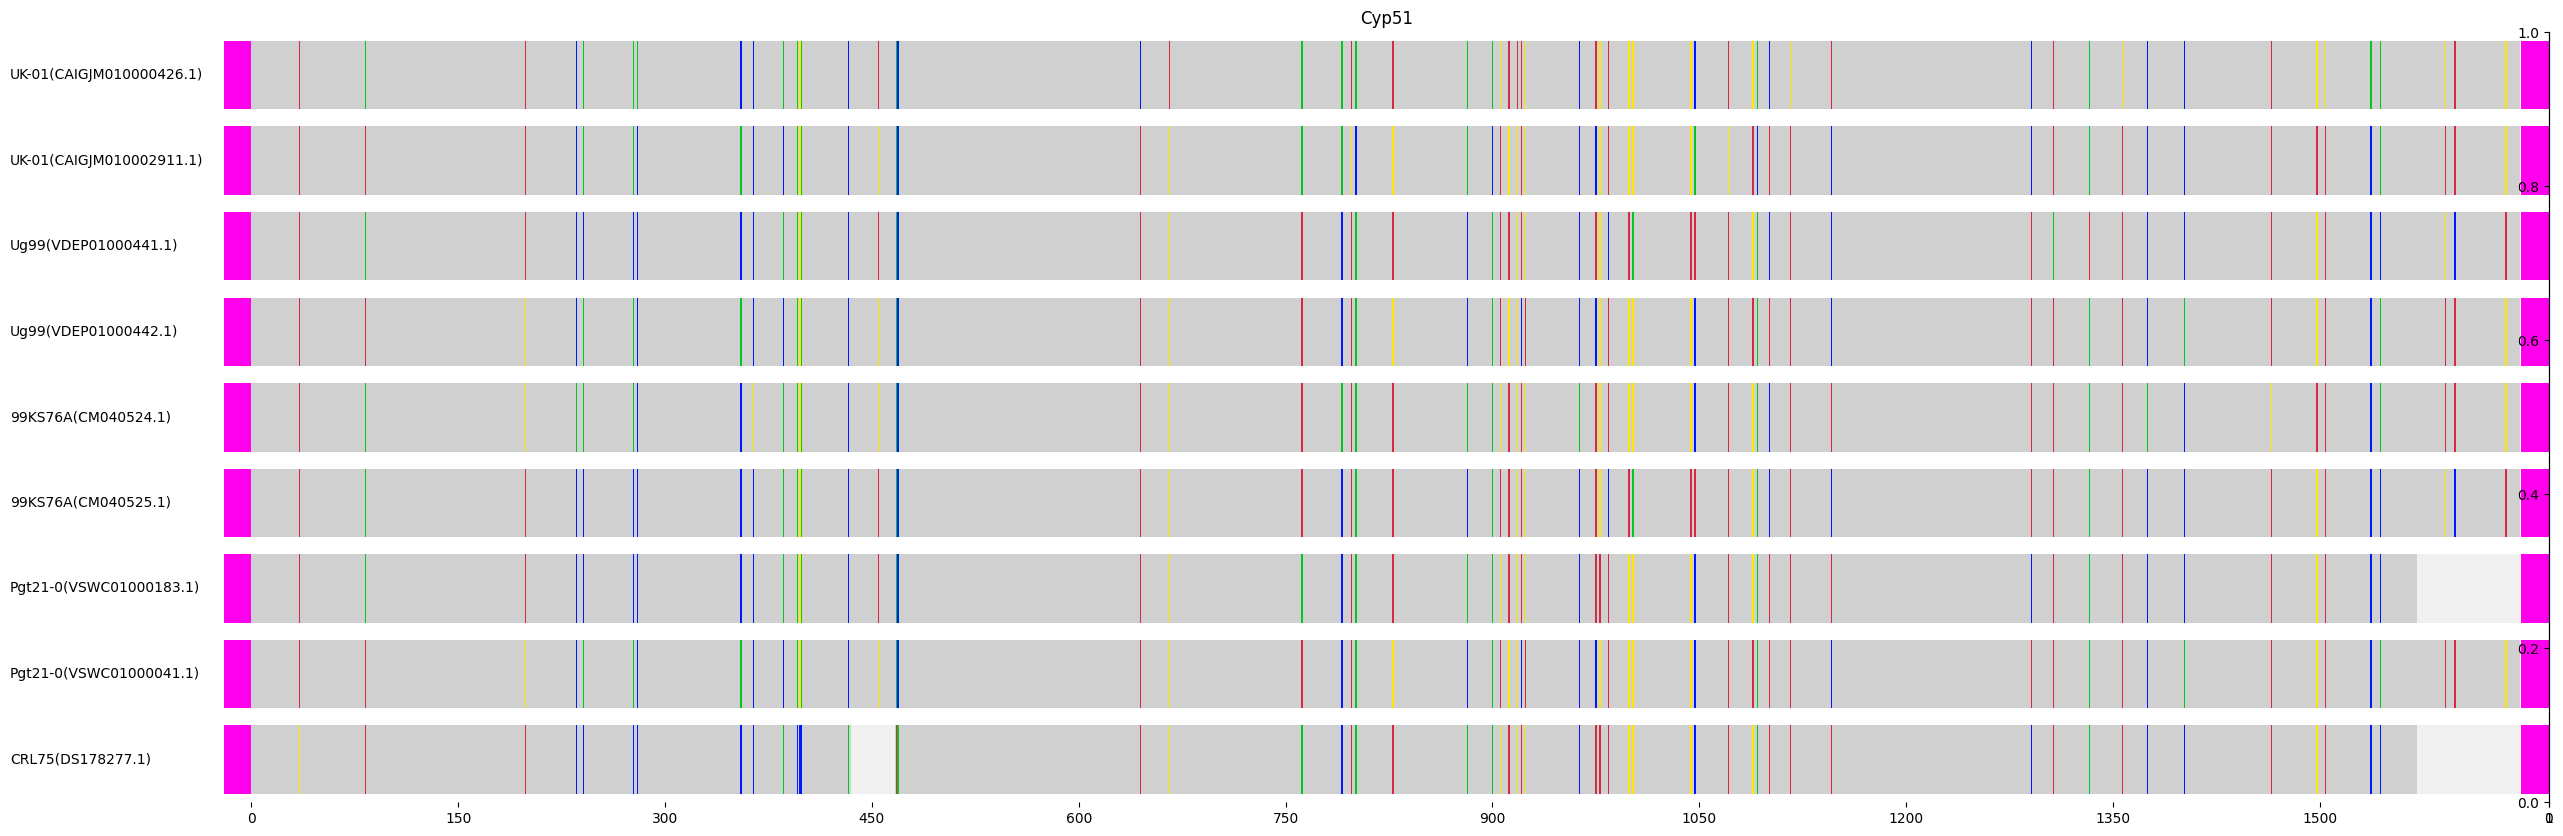

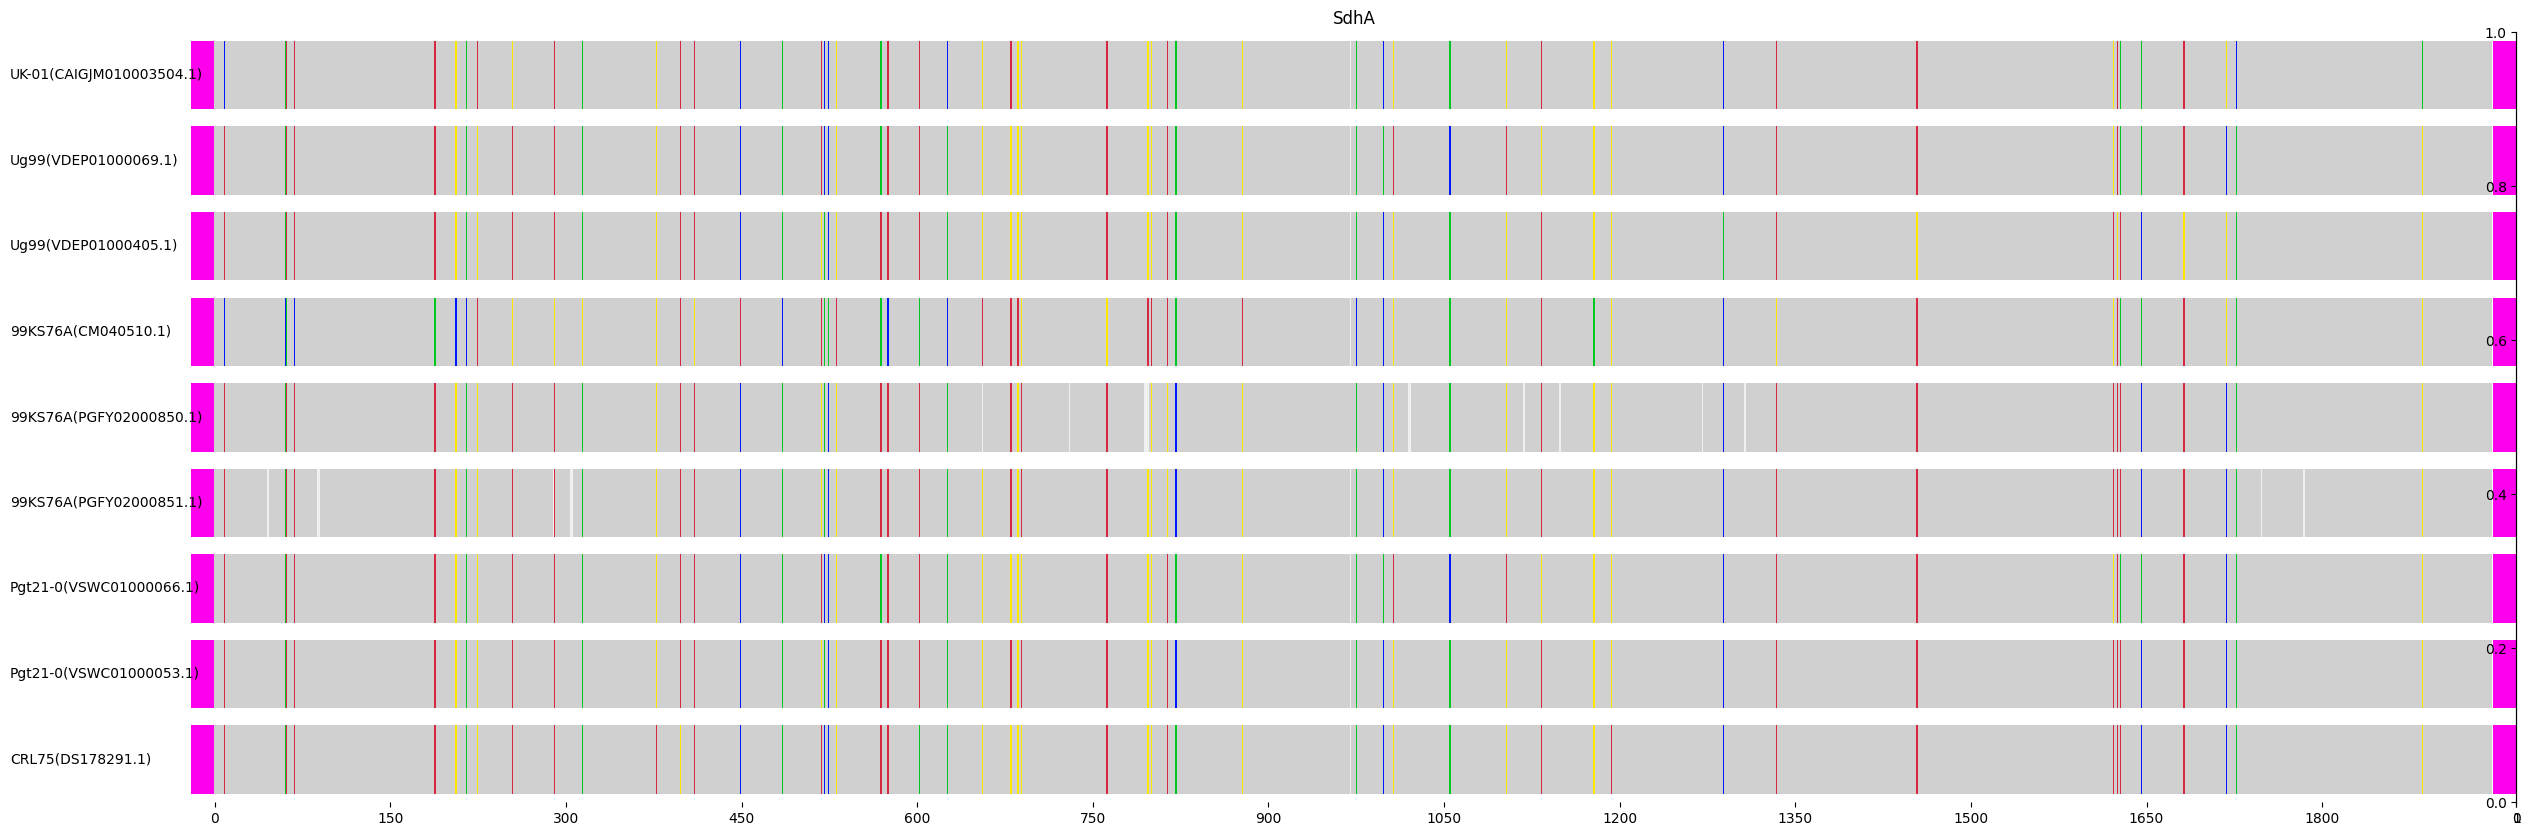

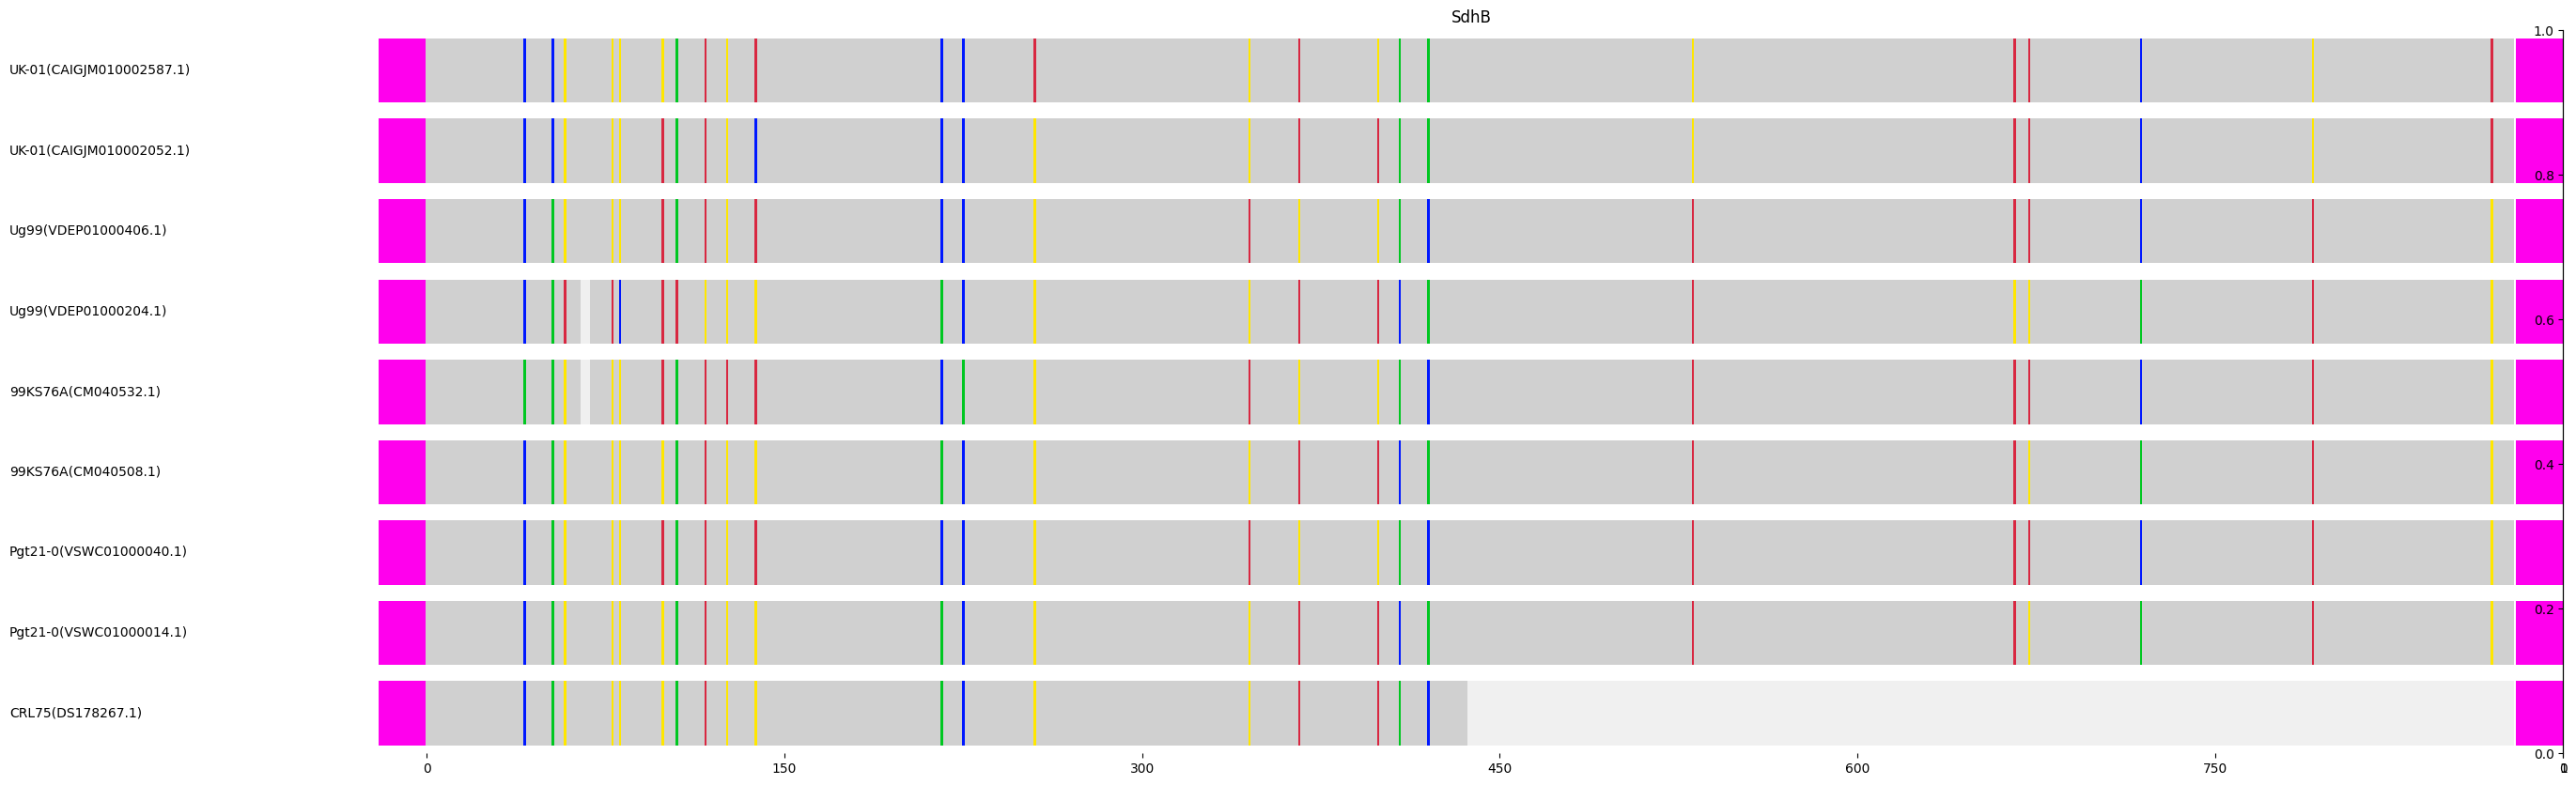

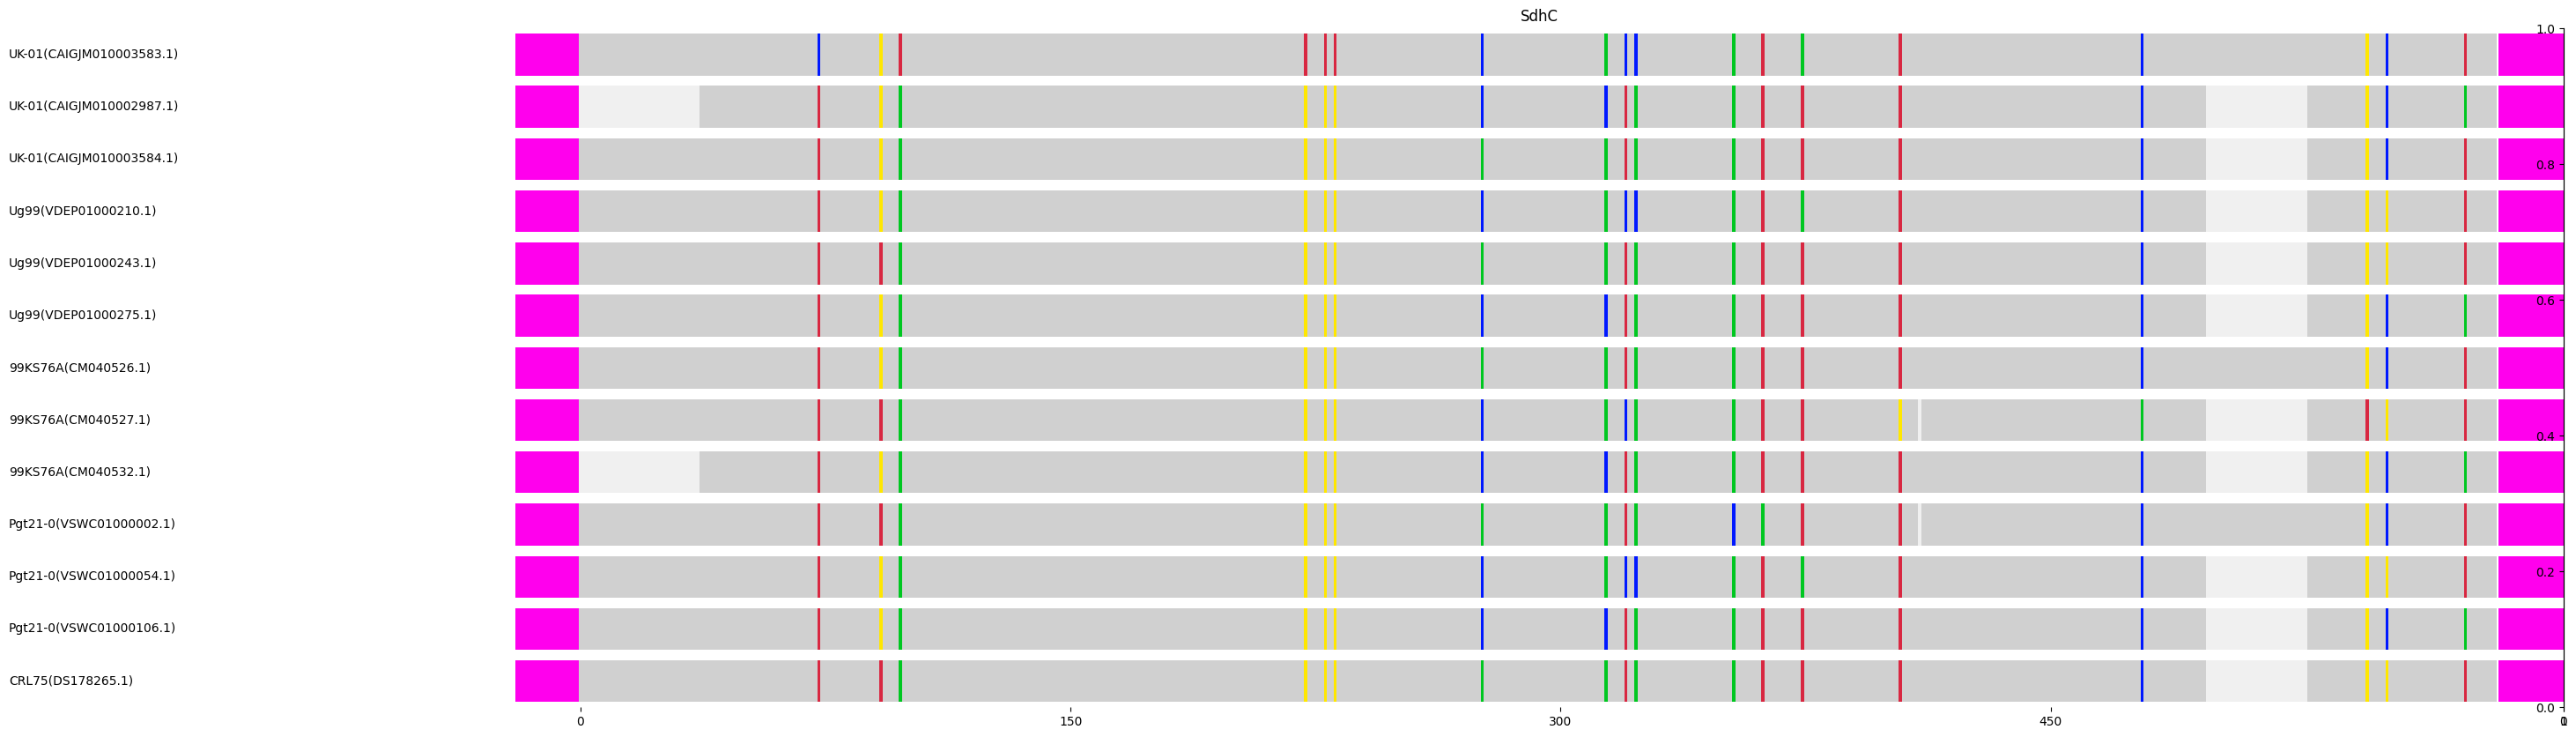

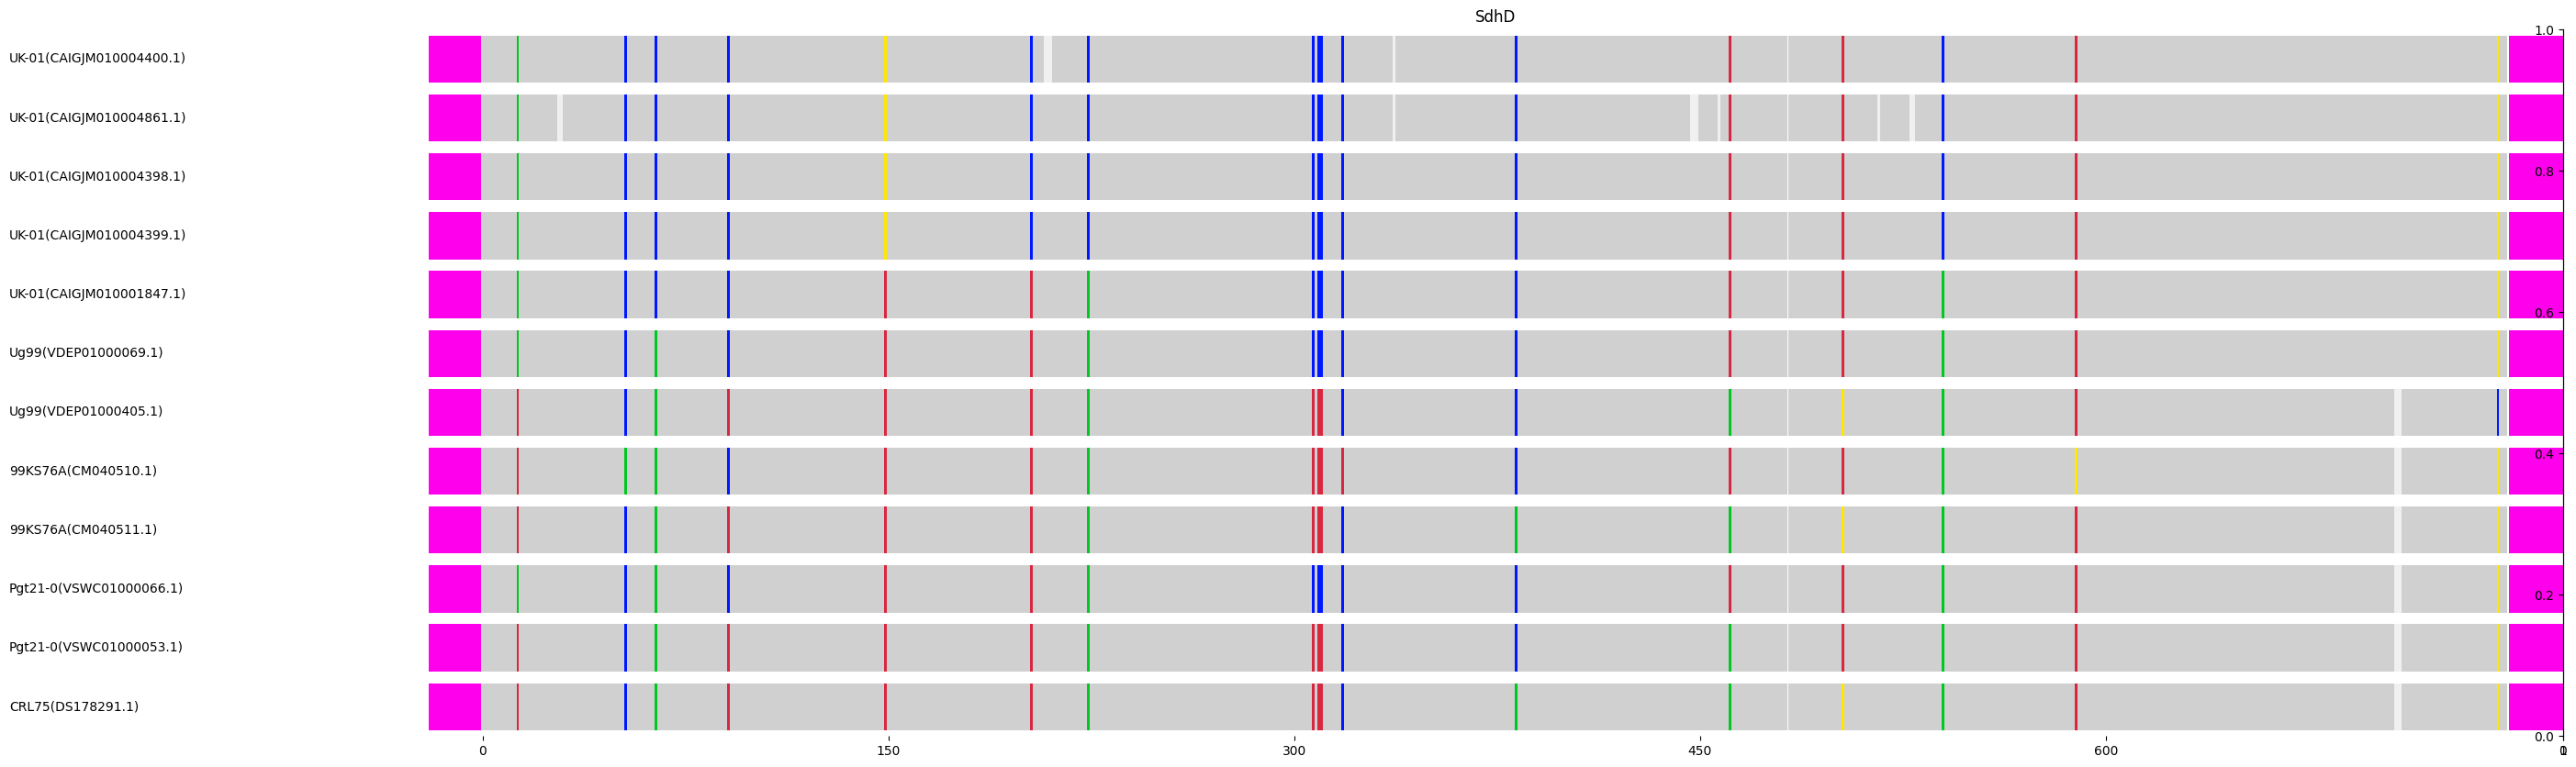

In [41]:
genes_of_interest = ['Cyp51','SdhA','SdhB','SdhC','SdhD']
for gene in genes_of_interest:
    gene_sequences = get_gene_sequences(sequences, gene)
    if gene_sequences:
        align_sequences(gene,gene_sequences)
        plot_alignment(gene, gene_sequences)
